In [19]:
#ACP _LDA

In [20]:
#Importation des packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold 

import xgboost as xgb


%matplotlib inline

C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [22]:
file='https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv'

In [23]:
#Charger les données

data=pd.read_csv(file)
data.head()


#Créer la timeline
timeline=data.apply(lambda x: datetime.strptime(x['GOLD_Time'],"%Y-%m-%d"),axis=1)[1:]


#Ajouter une variable "nombre de jours depuis le début"
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

my_min=min(data['GOLD_Time'])
data['day_to_start']=data.apply(lambda x: days_between(x['GOLD_Time'],my_min),axis=1)


#créer un df pour conserver la timeline
time_df=pd.DataFrame({'date':timeline,'day_to_start':data['day_to_start'][1:]})

#Supprimer la colonne temporelle de data
data=data.drop('GOLD_Time',axis=1)

In [24]:
#Remplacer les na par la valeur précédente non nulle

In [25]:
data.ffill(inplace=True)  



0

In [27]:
#Créer target et features

In [28]:
target=data.BTC_Close
target=target[1:]  #Retirer la première valeur

features=data.drop('BTC_Close',axis=1)
features=features[:-1]  #Retirer la dernières ligne

In [29]:
#Normalisation

scaler=MinMaxScaler()

#On conserve le day_to_date normalisé dans time_df (day_to_date est la dernière colonne)

feat_norm=pd.DataFrame(scaler.fit_transform(features))




C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [30]:
feat_norm.isnull().sum().sum()

0

In [51]:
pca=PCA(n_components=0.75)
pca.fit(feat_norm)


PCA(copy=True, iterated_power='auto', n_components=0.75, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
print('On peut voir que' , len(pca.explained_variance_ratio_) , 'components expliquent ',str(pca.explained_variance_ratio_.sum()) , 'de la variance.')


On peut voir que 5 components expliquent  0.7572178303519091 de la variance.


In [ ]:
data_12D=pca.fit(feat_norm)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter()

In [87]:
def test_components(df,nb_max_comp):
    var=[]
    for i in range(1,nb_max_comp+1):
        pca=PCA(n_components=i)
        pca.fit(df)
        print(len(pca.explained_variance_ratio_) , 'components expliquent ',round(pca.explained_variance_ratio_.sum(),2)*100 , '% de la variance.')
        var.append(pca.explained_variance_ratio_.sum())
    plt.plot(var)
    plt.xaxis=range(1,nb_max_comp+1)
    plt.ylabel('% variance explained');
    return var

1 components expliquent  45.0 % de la variance.
2 components expliquent  57.99999999999999 % de la variance.
3 components expliquent  66.0 % de la variance.
4 components expliquent  72.0 % de la variance.
5 components expliquent  76.0 % de la variance.
6 components expliquent  79.0 % de la variance.
7 components expliquent  82.0 % de la variance.
8 components expliquent  84.0 % de la variance.
9 components expliquent  86.0 % de la variance.
10 components expliquent  88.0 % de la variance.
11 components expliquent  90.0 % de la variance.
12 components expliquent  91.0 % de la variance.
13 components expliquent  92.0 % de la variance.
14 components expliquent  92.0 % de la variance.
15 components expliquent  93.0 % de la variance.
16 components expliquent  94.0 % de la variance.
17 components expliquent  94.0 % de la variance.
18 components expliquent  95.0 % de la variance.
19 components expliquent  95.0 % de la variance.
20 components expliquent  96.0 % de la variance.
21 components ex

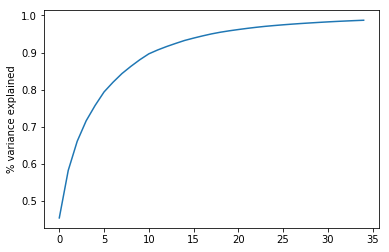

In [93]:
t_comp=test_components(feat_norm,35)

On peut voir que 35 components expliquent 99% de la variance.

In [102]:
#Regression linéaire
from sklearn.linear_model import LinearRegression

In [97]:
X_train,X_test,y_train,y_test=train_test_split(feat_norm,target,test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)




0.9996206850832687

Nous allons voir si les méthodes de réductions de dimension améliorent les scores sur une régression linéaire.

In [136]:
lr1=LinearRegression()
lr1.fit(X_train,y_train)
score_lr=lr1.score(X_test,y_test)


In [137]:
pca=PCA(n_components=0.9)
lr1.fit(X_train_pca,y_train)
score_pca=lr1.score(X_test_pca,y_test)

In [138]:
lda=LDA()
X_train_lda=lda.fit_transform(X_train,y_train)
X_test_lda=lda.transform(X_test)

lr1.fit(X_train_lda,y_train)
score_lda=lr1.score(X_test_lda,y_test)

C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Nous pouvons voir que le score avec LDA est très légèrement supérieur au score sans LDA. L'ACP ne donne pas de bons résultats.

In [145]:
print('R2 LR',score_lr)
print("R2 PCA LR",score_pca)
print("R2 LDA LR",score_lda)

R2 LR 0.9999870969029435
R2 PCA LR 0.8997873662230002
R2 LDA LR 0.9999871406399301
